# (Analysis of) Frequency-Recency Analysis

The goal of this notebook is to explore (part) of the functionality of the [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) package. The data is transformed the same way as in nb 2 and with help of the pre-fitted BG/NBD model general freq-rec analysis is performed and P(alive) is calculated on an individual customer level.

#### Data Source
- `data/interim/clv_data.csv`: Cleaned input data, prepared in nb 1.
- `data/interim/customers_data.csv`: Aggregated customer data, prepared in nb 1. (Used for ex-post analysis / comparison of results.)
- `models/bgf_model.pkl`: Fitted BG/NBD model from nb 2.

#### Changes
- 19-02-18: Start notebook, finish analysis


---

### Import libraries, load data & model

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
from lifetimes import BetaGeoFitter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(), sns.set_style('whitegrid')
%matplotlib inline  

# Special settings for lifetime plots
sns.set_palette("viridis")
sns.set(rc={'image.cmap': 'viridis'})

import cleaning_functions as clean
import EDA_functions as EDA

# Display Settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
# Load data
clv_data = pd.read_csv('data/interim/clv_data.csv', parse_dates=['InvoiceDate'],
                       dtype={'CustomerID' : str, 'Country' : 'category'})
customers_data = pd.read_csv('data/interim/customers_data.csv', index_col = 0,
                       parse_dates=['first_date', 'last_date'])
# Load model
bgf_loaded = BetaGeoFitter()
bgf_loaded.load_model('models/bgf_model.pkl')

## 1) Prepare Data


In [3]:
# Transform data to 'Lifetimes' format
clv_data.drop(['Quantity', 'UnitPrice', 'Country'], inplace=True, axis=1)
clv_data['InvoiceDate'] = clv_data['InvoiceDate'].dt.date

clv = summary_data_from_transaction_data(clv_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales')

In [4]:
# Check results
print(clv.shape)
clv.head()

(4338, 4)


,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


**Nomenclature for the CLV model:**

- _Frequency_: represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. (Thus if they have made only 1 purchase, the recency is 0.)
- _T_: represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- _Recency_: represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

## 2) Basic Frequency / Recency Analysis Using the BG / NBD Model
**Note:** This analysis is based on the model and calibration data from the last notebook. The data is passed with the model. The model is not fitted again on the (whole) data for this process. Hence we can see a maximal frequency of 60 and a maximal recency of 225.

(The 2 matrix functions compute P(alive) for all theoretical combinations of recency and frequency up to the maxima in the dataset given the parameters computed during the fit step. They assume customer age, T, to be equal to the maximum age of customers in the dataset.)

### Expected Number of Future Purchases for 1 Unit of Time by Freq / Rec

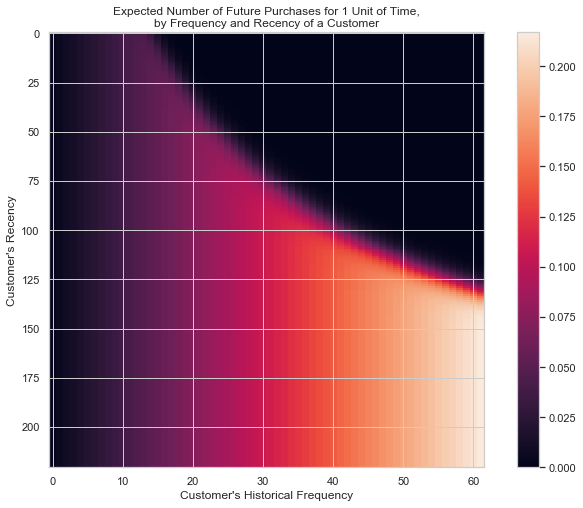

In [5]:
# Plot frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf_loaded);

**Explanation:** Consider a customer bought from you every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

- Our best customer is one that has made 60+ purchases, and his latest purchase was when he was approximately 225 days old (bottom-right). Customers who have purchased a lot and purchased recently will likely be the best customers in the future. 
- Customers who have purchased a lot in the past but we have not heard from them for long are the 'coldest', they have probably churned away (top-right corner).
- There’s also that  “tail” around (10, 25-200). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

### Probability Customer is Alive by Freq / Rec

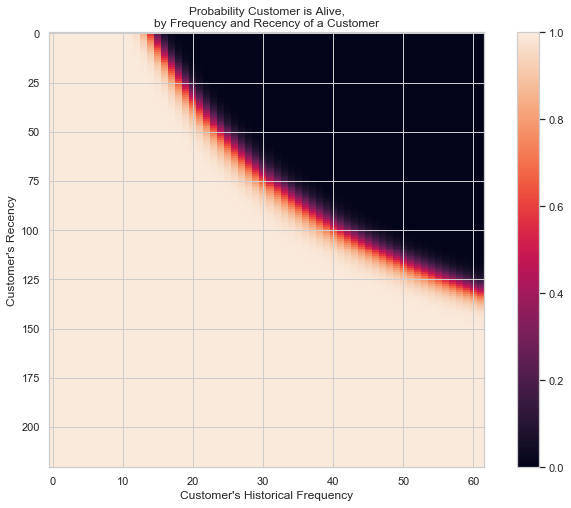

In [7]:
# plot probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf_loaded);

**Observation:** The picture is quite digital with many ones and zeroes, and only a small rim of intermediate probabilities in between.

---

## Deep-dive: Analyse P(alive) on whole data set

In [8]:
# Fit BGF on whole dataset
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.95, b: 2.03, r: 0.83>


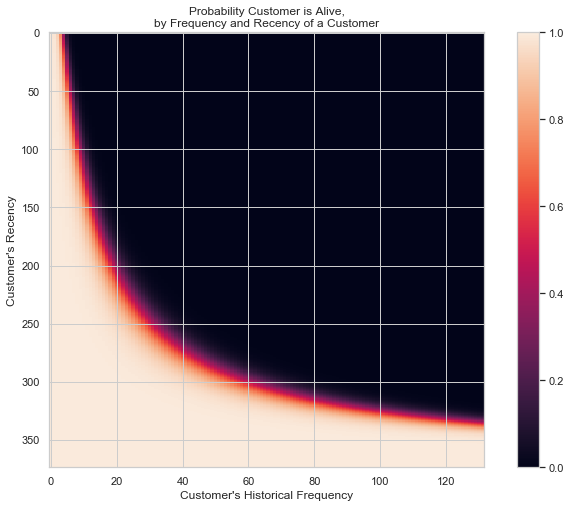

In [10]:
# plot probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf);

min: 0.8, max 1.0


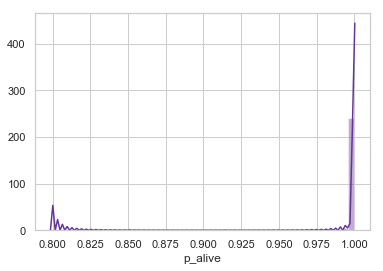

In [13]:
# Calculate P(alive) for indivdual customers, append to df
clv["p_alive"] = bgf.conditional_probability_alive(clv["frequency"], 
                                                   clv ["recency"], 
                                                   clv ["T"])
# Display results
print("min: {}, max {}".format(round(np.min(clv["p_alive"]),2),
                                     np.max(clv["p_alive"])))
sns.distplot(clv['p_alive'], color='rebeccapurple');

**Observation:** The majority of customers has P(alive) = 1.0, the lowest score in the set is around 0.8.

The high proportion of 1.0 can be explained when looking at the assumptions of the BG/NBD model: If we calculate P(alive) with this model, the probability score defaults to 1 for users that have no frequency (one-time purchasers). The Bruce Hardie paper that can be found in the `resources` section states: _"We note that P(alive) = 1 for a customer who made no purchases in the interval (0, T]; this follows from the model’s assumptions that death occurs after a purchase and that customers are alive at the beginning of the observation period._

class BetaGeoFitter(). This model has the following assumptions:
1. Each individual, `i`, has a hidden `lambda_i` and `p_i` parameter
2. These come from a population wide Gamma and a Beta distribution respectively.
3. Individuals purchases follow a Poisson process with rate `lambda_i*t` .
4. *After each purchase, an individual has a p_i probability of dieing (never buying again).*

Statement Cameron concerning this issue: Agree. Part of the problem, I suspect, is that you are using a model that doesn't allow many deaths! If you are using the BG/NBD model, take a look at the "customer story" again. Remember that deaths can only happen after a purchase event, and if a customer only makes 1 purchase every ~15months, then that's a very low chance of dying each month. Does that make sense? Generally, I'm now advocating for the BG/BB model instead of the BG/NBD model because of the internal paradox in the BG/NBD "customer story".

(See paper on BG/BB model, seems suited to discrete-non contractual situations and not to continuous ones.)


In [30]:
# Look at customers with lowest P(alive)
customers_data.index = customers_data.index.map(str)
customers = pd.concat([customers_data, clv[['p_alive']]], axis=1, sort=True)
customers.sort_values(['p_alive']).head()

,first_date,last_date,T,frequency,recency,Sales,avg_freq,sleeping,p_alive
CustomerID,,,,,,,,,
15107,2010-12-02,2011-02-01,372,5,61,319.50,12.0,311,0.798872
16725,2010-12-03,2011-02-10,371,5,69,781.02,14.0,302,0.850763
13093,2010-12-01,2011-03-09,373,6,98,7832.47,16.0,275,0.881418
15235,2010-12-01,2011-05-06,373,9,156,2247.51,17.0,217,0.914596
12845,2011-02-22,2011-03-17,290,3,23,354.09,8.0,267,0.947017


**Observation:** I would consider them stone dead ... ;-). Honestly, I think the probabilities are very optimistic, but I would have to verify this on an other dataset.

---